In [57]:
import torch
from transformers import (
    BertTokenizer, BertForSequenceClassification, BertModel,
    TrainingArguments, Trainer, DataCollatorWithPadding
)
from datasets import load_dataset, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
import re
import os
from tqdm import tqdm
import json
from datetime import datetime

In [58]:


# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =============================================================================
# A1. SETUP & DATA PREPARATION
# =============================================================================

def load_sst2_dataset():
    """Load SST-2 dataset from HuggingFace"""
    dataset = load_dataset("glue", "sst2")
    return dataset

def create_demographic_names():
    """Create lists of male and female names for demographic analysis"""
    male_names = [
        "James", "John", "Robert", "Michael", "William", "David", "Richard", 
        "Joseph", "Thomas", "Christopher", "Charles", "Daniel", "Matthew", 
        "Anthony", "Mark", "Donald", "Steven", "Paul", "Andrew", "Joshua"
    ]
    
    female_names = [
        "Mary", "Patricia", "Jennifer", "Linda", "Elizabeth", "Barbara", 
        "Susan", "Jessica", "Sarah", "Karen", "Nancy", "Lisa", "Betty", 
        "Helen", "Sandra", "Donna", "Carol", "Ruth", "Sharon", "Michelle"
    ]
    
    return male_names, female_names

def detect_demographic_mentions(text, male_names, female_names):
    """
    Detect if text contains demographic mentions (names or pronouns)
    Returns: 'male', 'female', or 'neutral'
    """
    text_lower = text.lower()
    
    # Check for names
    for name in male_names:
        if name.lower() in text_lower:
            return 'male'
    
    for name in female_names:
        if name.lower() in text_lower:
            return 'female'
    
    # Check for pronouns
    male_pronouns = ['he', 'his', 'him', 'himself']
    female_pronouns = ['she', 'her', 'hers', 'herself']
    
    # Use word boundaries to avoid partial matches
    for pronoun in male_pronouns:
        if re.search(r'\b' + pronoun + r'\b', text_lower):
            return 'male'
    
    for pronoun in female_pronouns:
        if re.search(r'\b' + pronoun + r'\b', text_lower):
            return 'female'
    
    return 'neutral'

def create_demographic_annotated_dataset(dataset, male_names, female_names):
    """Add demographic annotations to SST-2 dataset"""
    
    def add_demographic_info(example):
        demographic = detect_demographic_mentions(example['sentence'], male_names, female_names)
        example['demographic'] = demographic
        return example
    
    # Annotate all splits
    annotated_dataset = {}
    for split_name in dataset.keys():
        annotated_dataset[split_name] = dataset[split_name].map(add_demographic_info)
    
    return annotated_dataset

def create_demographic_test_sets(annotated_dataset, test_split_ratio=0.15):
    """
    Create separate test sets for demographic analysis
    
    Since GLUE test set has no labels, we split training data to create
    a proper test set with demographic annotations and ground truth labels.
    """
    from sklearn.model_selection import train_test_split
    
    # Convert training data to pandas for easier splitting
    train_data = annotated_dataset['train']
    
    # Extract data for splitting
    sentences = list(train_data['sentence'])
    labels = list(train_data['label'])
    demographics = list(train_data['demographic'])
    
    # Stratified split to maintain label distribution
    train_sentences, test_sentences, train_labels, test_labels, train_demos, test_demos = train_test_split(
        sentences, labels, demographics,
        test_size=test_split_ratio,
        stratify=labels,  # Maintain sentiment label balance
        random_state=42
    )
    
    # Create new train/test datasets
    new_train_data = Dataset.from_dict({
        'sentence': train_sentences,
        'label': train_labels,
        'demographic': train_demos
    })
    
    test_data = Dataset.from_dict({
        'sentence': test_sentences,
        'label': test_labels,
        'demographic': test_demos
    })
    
    # Split test data by demographic groups
    male_examples = test_data.filter(lambda x: x['demographic'] == 'male')
    female_examples = test_data.filter(lambda x: x['demographic'] == 'female')
    neutral_examples = test_data.filter(lambda x: x['demographic'] == 'neutral')
    
    demographic_splits = {
        'male': male_examples,
        'female': female_examples,
        'neutral': neutral_examples,
        'all': test_data
    }
    
    # Print statistics
    print("Demographic distribution in test set:")
    for demo, data in demographic_splits.items():
        print(f"  {demo}: {len(data)} examples")
    
    print(f"\nDataset split summary:")
    print(f"  Original train: {len(annotated_dataset['train'])} examples")
    print(f"  New train: {len(new_train_data)} examples")
    print(f"  New test: {len(test_data)} examples")
    print(f"  Validation (for eval): {len(annotated_dataset['validation'])} examples")
    
    # Update the annotated dataset with new split
    annotated_dataset['train'] = new_train_data
    annotated_dataset['test'] = test_data
    
    return demographic_splits, annotated_dataset

def create_mini_seat_examples():
    """Create lightweight SEAT examples for frequent bias measurement"""
    
    # Target groups: Male and female names in simple contexts
    male_names = ["James", "John", "Robert", "Michael"]
    female_names = ["Mary", "Patricia", "Jennifer", "Linda"]
    
    male_sentences = [f"{name} is a person." for name in male_names]
    female_sentences = [f"{name} is a person." for name in female_names]
    
    # Attribute groups: Career vs. family oriented (simplified)
    career_attributes = [
        "The executive makes decisions.",
        "The engineer solves problems.", 
        "The manager leads teams.",
        "The analyst studies data."
    ]
    
    family_attributes = [
        "The caregiver helps others.",
        "The teacher nurtures students.",
        "The nurse provides care.",
        "The assistant offers support."
    ]
    
    return {
        'male_targets': male_sentences,
        'female_targets': female_sentences,
        'career_attributes': career_attributes,
        'family_attributes': family_attributes
    }

def preprocess_sst2_for_training(dataset, tokenizer, max_length=128):
    """Preprocess SST-2 data for training"""
    
    def tokenize_function(examples):
        return tokenizer(
            examples['sentence'],
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='pt'
        )
    
    tokenized_dataset = {}
    for split_name in ['train', 'validation']:
        if split_name in dataset:
            # Get current columns to determine which ones to remove
            current_columns = dataset[split_name].column_names
            columns_to_remove = [col for col in current_columns if col not in ['label']]
            
            tokenized_dataset[split_name] = dataset[split_name].map(
                tokenize_function,
                batched=True,
                remove_columns=columns_to_remove
            )
    
    return tokenized_dataset

# =============================================================================
# A2. BIAS MEASUREMENT FUNCTIONS
# =============================================================================

def get_sentence_embedding(text, model, tokenizer, pooling='cls'):
    """Extract sentence embedding from model"""
    inputs = tokenizer(text, return_tensors='pt', padding=True, 
                      truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    with torch.no_grad():
        # Handle both base BERT and sequence classification models
        if hasattr(model, 'bert'):
            outputs = model.bert(**inputs)
        else:
            outputs = model(**inputs, output_hidden_states=True)
            outputs = outputs.hidden_states[-1] if hasattr(outputs, 'hidden_states') else outputs.last_hidden_state
        
        if hasattr(outputs, 'last_hidden_state'):
            hidden_states = outputs.last_hidden_state[0]
        else:
            hidden_states = outputs[0]
    
    if pooling == 'cls':
        return hidden_states[0].cpu().numpy()
    elif pooling == 'mean':
        attention_mask = inputs['attention_mask'][0]
        masked_embeddings = hidden_states * attention_mask.unsqueeze(-1)
        return (masked_embeddings.sum(dim=0) / attention_mask.sum()).cpu().numpy()

def calculate_mini_seat_score(seat_examples, model, tokenizer):
    """Calculate SEAT bias score for current model state"""
    
    # Get embeddings for all groups
    male_embeddings = [get_sentence_embedding(sent, model, tokenizer) 
                      for sent in seat_examples['male_targets']]
    female_embeddings = [get_sentence_embedding(sent, model, tokenizer) 
                        for sent in seat_examples['female_targets']]
    career_embeddings = [get_sentence_embedding(sent, model, tokenizer) 
                        for sent in seat_examples['career_attributes']]
    family_embeddings = [get_sentence_embedding(sent, model, tokenizer) 
                        for sent in seat_examples['family_attributes']]
    
    # Calculate association scores
    male_scores = []
    female_scores = []
    
    for male_emb in male_embeddings:
        career_sim = np.mean([cosine_similarity([male_emb], [career_emb])[0][0] 
                             for career_emb in career_embeddings])
        family_sim = np.mean([cosine_similarity([male_emb], [family_emb])[0][0] 
                             for family_emb in family_embeddings])
        male_scores.append(career_sim - family_sim)
    
    for female_emb in female_embeddings:
        career_sim = np.mean([cosine_similarity([female_emb], [career_emb])[0][0] 
                             for career_emb in career_embeddings])
        family_sim = np.mean([cosine_similarity([female_emb], [family_emb])[0][0] 
                             for family_emb in family_embeddings])
        female_scores.append(career_sim - family_sim)
    
    # Calculate effect size
    mean_diff = np.mean(male_scores) - np.mean(female_scores)
    pooled_std = np.sqrt((np.var(male_scores) + np.var(female_scores)) / 2)
    effect_size = mean_diff / pooled_std if pooled_std > 0 else 0
    
    return effect_size, male_scores, female_scores

def evaluate_demographic_performance(model, tokenizer, demographic_test_sets):
    """Evaluate model performance across demographic groups"""
    
    results = {}
    
    for demographic, test_data in demographic_test_sets.items():
        if len(test_data) == 0:
            continue
            
        predictions = []
        true_labels = []
        confidences = []
        
        model.eval()
        for example in test_data:
            inputs = tokenizer(
                example['sentence'],
                return_tensors='pt',
                padding=True,
                truncation=True,
                max_length=512
            )
            inputs = {k: v.to(model.device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits
                probs = torch.softmax(logits, dim=-1)
                
                prediction = torch.argmax(logits, dim=-1).item()
                confidence = torch.max(probs).item()
                
                predictions.append(prediction)
                true_labels.append(example['label'])
                confidences.append(confidence)
        
        accuracy = accuracy_score(true_labels, predictions)
        avg_confidence = np.mean(confidences)
        
        results[demographic] = {
            'accuracy': accuracy,
            'avg_confidence': avg_confidence,
            'n_examples': len(test_data),
            'predictions': predictions,
            'true_labels': true_labels,
            'confidences': confidences
        }
    
    return results

def measure_current_bias_state(model, tokenizer, seat_examples, demographic_test_sets):
    """Comprehensive bias measurement at current model state"""
    
    # SEAT bias measurement
    seat_effect_size, male_scores, female_scores = calculate_mini_seat_score(
        seat_examples, model, tokenizer
    )
    
    # Demographic performance evaluation
    demographic_results = evaluate_demographic_performance(
        model, tokenizer, demographic_test_sets
    )
    
    # Calculate performance gaps
    performance_gaps = {}
    if 'male' in demographic_results and 'female' in demographic_results:
        male_acc = demographic_results['male']['accuracy']
        female_acc = demographic_results['female']['accuracy']
        male_conf = demographic_results['male']['avg_confidence']
        female_conf = demographic_results['female']['avg_confidence']
        
        performance_gaps = {
            'accuracy_gap': male_acc - female_acc,
            'confidence_gap': male_conf - female_conf,
            'male_accuracy': male_acc,
            'female_accuracy': female_acc
        }
    
    bias_state = {
        'seat_effect_size': seat_effect_size,
        'seat_male_scores': male_scores,
        'seat_female_scores': female_scores,
        'demographic_performance': demographic_results,
        'performance_gaps': performance_gaps
    }
    
    return bias_state

In [59]:
from transformers import TrainerCallback

def create_bias_tracking_trainer(model, tokenizer, train_dataset, eval_dataset, 
                                seat_examples, demographic_test_sets, 
                                bias_check_steps, output_dir="./bias_tracking_results"):
    """Create trainer with bias tracking callbacks"""
    
    training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=3,
    max_steps=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_dir=f'{output_dir}/logs',
    logging_steps=100,
    eval_strategy="steps",              # <-- must be set
    eval_steps=500,
    save_strategy="steps",              # <-- added to match
    save_steps=500,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    fp16=True,
    lr_scheduler_type="linear",
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
)


    
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        return {"accuracy": accuracy_score(labels, predictions)}
    
    # Store bias tracking data
    bias_trajectory = {}
    
    class BiasTrackingCallback(TrainerCallback): 
        def __init__(self):
            super().__init__()  
            self.step_count = 0
            
        def on_step_end(self, args, state, control, model=None, **kwargs):
            self.step_count += 1
            
            # Check bias every N steps
            if self.step_count % bias_check_steps == 0:
                print(f"\n📊 Measuring bias at step {int(state.global_step)}...")
                
                bias_state = measure_current_bias_state(
                    model, tokenizer, seat_examples, demographic_test_sets
                )
                
                bias_trajectory[int(state.global_step)] = {
                    'step': int(state.global_step),
                    'epoch': float(state.epoch),
                    'bias_state': bias_state,
                    'timestamp': datetime.now().isoformat()
                }
                
                # Print current bias metrics
                seat_score = bias_state['seat_effect_size']
                perf_gaps = bias_state['performance_gaps']
                
                print(f"   SEAT Effect Size: {seat_score:.4f}")
                if perf_gaps:
                    print(f"   Accuracy Gap: {perf_gaps['accuracy_gap']:.4f}")
                    print(f"   Confidence Gap: {perf_gaps['confidence_gap']:.4f}")
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[BiasTrackingCallback()]
    )
    
    trainer.bias_trajectory = bias_trajectory
    
    return trainer

In [60]:

tokenizer_name='bert-base-uncased'
output_dir="./bias_tracking_results"

print("🚀 Starting Bias Propagation Tracking Analysis")
print("=" * 60)

# Setup
print("📋 Step 1: Loading data and models...")
tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
model = BertForSequenceClassification.from_pretrained(tokenizer_name, num_labels=2)
model.to(device)

🚀 Starting Bias Propagation Tracking Analysis
📋 Step 1: Loading data and models...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [61]:

# Load and prepare data
sst2_dataset = load_sst2_dataset()
male_names, female_names = create_demographic_names()
annotated_dataset = create_demographic_annotated_dataset(sst2_dataset, male_names, female_names)
demographic_test_sets, annotated_dataset = create_demographic_test_sets(annotated_dataset)

# Prepare training data (now using the new train split)
tokenized_dataset = preprocess_sst2_for_training(annotated_dataset, tokenizer)
train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['validation']  # Use original validation for evaluation

# Create SEAT examples
seat_examples = create_mini_seat_examples()

Filter: 100%|██████████| 10103/10103 [00:00<00:00, 137836.88 examples/s]


Demographic distribution in test set:
  male: 517 examples
  female: 156 examples
  neutral: 9430 examples
  all: 10103 examples

Dataset split summary:
  Original train: 67349 examples
  New train: 57246 examples
  New test: 10103 examples
  Validation (for eval): 872 examples


Map: 100%|██████████| 57246/57246 [00:21<00:00, 2691.98 examples/s]


In [62]:
# print("📊 Step 2: Measuring initial bias state...")
# initial_bias_state = measure_current_bias_state(
#     model, tokenizer, seat_examples, demographic_test_sets
# )

# print(f"   Initial SEAT Effect Size: {initial_bias_state['seat_effect_size']:.4f}")
# if initial_bias_state['performance_gaps']:
#     print(f"   Initial Accuracy Gap: {initial_bias_state['performance_gaps']['accuracy_gap']:.4f}")

SEAT Effect Size of 2.9303 is quite high. SEAT (Sentence Encoder Association Test) measures implicit associations, and effect sizes above 2 typically indicate strong unwanted biases. For context, effect sizes around 0.5-1.0 are considered moderate, so 2.9 suggests the model has learned fairly pronounced stereotypical associations.
Accuracy Gap of 0.0285 means there's about a 2.85 percentage point difference in performance across different demographic groups. While this might seem small, it can compound into significant fairness issues at scale, especially in high-stakes applications.
The combination is particularly noteworthy - you have both implicit bias (SEAT) and performance disparities (accuracy gap) occurring together. This suggests the bias isn't just in the model's internal representations but is actually affecting its outputs differently for different groups.
For comparison, well-debiased models typically aim for SEAT effect sizes below 1.0 and accuracy gaps under 1%. Your current state suggests you'll want to apply bias mitigation techniques before deployment, especially if this model will be used in contexts affecting people's opportunities or experiences.

In [63]:
print("🏋️ Step 3: Starting fine-tuning with bias tracking...")
trainer = create_bias_tracking_trainer(
    model, tokenizer, train_dataset, eval_dataset,
    seat_examples, demographic_test_sets,
    bias_check_steps=1,
    output_dir=output_dir
)

# Train model
trainer.train()

🏋️ Step 3: Starting fine-tuning with bias tracking...


C:\Users\a4293604\AppData\Local\Temp\ipykernel_10100\2113326707.py:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\a4293604\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



📊 Measuring bias at step 1...
   SEAT Effect Size: 0.7503
   Accuracy Gap: 0.0285
   Confidence Gap: 0.0007


Step,Training Loss,Validation Loss



📊 Measuring bias at step 2...
   SEAT Effect Size: 0.4328
   Accuracy Gap: 0.0285
   Confidence Gap: 0.0011

📊 Measuring bias at step 3...
   SEAT Effect Size: 0.0902
   Accuracy Gap: 0.0304
   Confidence Gap: 0.0017


TrainOutput(global_step=3, training_loss=0.7692433993021647, metrics={'train_runtime': 1844.1905, 'train_samples_per_second': 0.052, 'train_steps_per_second': 0.002, 'total_flos': 6314665328640.0, 'train_loss': 0.7692433993021647, 'epoch': 0.0016769144773616546})

In [64]:
print("📊 Step 4: Measuring final bias state...")
final_bias_state = measure_current_bias_state(
    model, tokenizer, seat_examples, demographic_test_sets
)

📊 Step 4: Measuring final bias state...


In [65]:
print(f"   Final SEAT Effect Size: {final_bias_state['seat_effect_size']:.4f}")
if final_bias_state['performance_gaps']:
    print(f"   Final Accuracy Gap: {final_bias_state['performance_gaps']['accuracy_gap']:.4f}")

complete_results = {
    'initial_bias_state': initial_bias_state,
    'bias_trajectory': trainer.bias_trajectory,
    'final_bias_state': final_bias_state,
    'model': model,
    'tokenizer': tokenizer,
    'demographic_test_sets': demographic_test_sets,
    'seat_examples': seat_examples
}

# Save results
os.makedirs(output_dir, exist_ok=True)

def ensure_json_serializable(obj):
    """Recursively convert numpy types to Python natives"""
    if isinstance(obj, dict):
        return {key: ensure_json_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [ensure_json_serializable(item) for item in obj]
    elif isinstance(obj, (np.integer, np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

trajectory_for_save = {
    'initial_bias_state': ensure_json_serializable({k: v for k, v in initial_bias_state.items() 
                                                   if k not in ['seat_male_scores', 'seat_female_scores']}),
    'bias_trajectory': {str(step): {
        'step': int(data['step']),
        'epoch': float(data['epoch']),
        'seat_effect_size': float(data['bias_state']['seat_effect_size']),
        'performance_gaps': ensure_json_serializable(data['bias_state']['performance_gaps']),  # ← Fix this
        'timestamp': data['timestamp']
    } for step, data in trainer.bias_trajectory.items()},
    'final_bias_state': ensure_json_serializable({k: v for k, v in final_bias_state.items() 
                                                 if k not in ['seat_male_scores', 'seat_female_scores']})
}

with open(f"{output_dir}/bias_trajectory.json", 'w') as f:
    json.dump(trajectory_for_save, f, indent=2)

print(f"✅ Results saved to {output_dir}/")
print("🎉 Bias propagation tracking complete!")



   Final SEAT Effect Size: 2.2262
   Final Accuracy Gap: 0.0304
✅ Results saved to ./bias_tracking_results/
🎉 Bias propagation tracking complete!


In [66]:
def plot_bias_evolution(bias_trajectory, output_dir="./bias_tracking_results"):
    """Plot how bias evolves during training"""
    
    if not bias_trajectory:
        print("No bias trajectory data to plot!")
        return
    
    # Extract data for plotting - Updated for your data structure
    steps = []
    seat_scores = []
    accuracy_gaps = []
    confidence_gaps = []
    
    for step, data in sorted(bias_trajectory.items(), key=lambda x: int(x[0]) if isinstance(x[0], str) else x[0]):
        steps.append(int(step))
        # Fixed path - your data has seat_effect_size under bias_state
        seat_scores.append(float(data['bias_state']['seat_effect_size']))
        
        if data['bias_state'].get('performance_gaps'):
            accuracy_gaps.append(abs(float(data['bias_state']['performance_gaps']['accuracy_gap'])))
            confidence_gaps.append(abs(float(data['bias_state']['performance_gaps']['confidence_gap'])))
        else:
            accuracy_gaps.append(0.0)
            confidence_gaps.append(0.0)
    
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: SEAT Effect Size Evolution
    ax1.plot(steps, seat_scores, 'b-o', linewidth=2, markersize=6)
    ax1.set_xlabel('Training Step')
    ax1.set_ylabel('SEAT Effect Size')
    ax1.set_title('SEAT Bias Evolution During Fine-tuning')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    # Add trend annotation
    if len(seat_scores) > 1:
        trend = "Increasing" if seat_scores[-1] > seat_scores[0] else "Decreasing"
        change = abs(seat_scores[-1] - seat_scores[0])
        ax1.text(0.05, 0.95, f'Trend: {trend}\nChange: {change:.3f}', 
                transform=ax1.transAxes, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    # Plot 2: Accuracy Gap Evolution
    ax2.plot(steps, accuracy_gaps, 'r-s', linewidth=2, markersize=6)
    ax2.set_xlabel('Training Step')
    ax2.set_ylabel('Accuracy Gap (Absolute Value)')
    ax2.set_title('Performance Gap Evolution During Fine-tuning')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Plot 3: Confidence Gap Evolution
    ax3.plot(steps, confidence_gaps, 'g-^', linewidth=2, markersize=6)
    ax3.set_xlabel('Training Step')
    ax3.set_ylabel('Confidence Gap (Absolute Value)')
    ax3.set_title('Confidence Gap Evolution During Fine-tuning')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Plot 4: Combined Evolution
    ax4_twin = ax4.twinx()
    
    line1 = ax4.plot(steps, seat_scores, 'b-o', linewidth=2, label='SEAT Effect Size')
    line2 = ax4_twin.plot(steps, accuracy_gaps, 'r-s', linewidth=2, label='Accuracy Gap')
    
    ax4.set_xlabel('Training Step')
    ax4.set_ylabel('SEAT Effect Size', color='b')
    ax4_twin.set_ylabel('Accuracy Gap', color='r')
    ax4.set_title('Combined Bias Evolution')
    ax4.grid(True, alpha=0.3)
    
    # Combined legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax4.legend(lines, labels, loc='upper right')
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/bias_evolution_plots.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

def analyze_bias_propagation_patterns(bias_trajectory, initial_bias_state, final_bias_state):
    """Analyze patterns in bias propagation - Fixed for your data structure"""
    
    print("\n" + "="*60)
    print("📈 BIAS PROPAGATION ANALYSIS")
    print("="*60)
    
    # Check if we have any trajectory data
    if not bias_trajectory:
        print("⚠️ No bias trajectory data available")
        return {
            'bias_change': 0,
            'percent_change': 0,
            'trend_slope': None,
            'trend_r_squared': None,
            'critical_step': None,
            'max_change': None
        }
    
    # Extract trajectory data - Fixed for your structure with bias_state nesting
    steps = sorted([int(k) for k in bias_trajectory.keys()])
    seat_scores = [float(bias_trajectory[step]['bias_state']['seat_effect_size']) for step in steps]
    
    initial_seat = initial_bias_state['seat_effect_size']
    final_seat = final_bias_state['seat_effect_size']
    
    print(f"\n🎯 OVERALL BIAS CHANGE:")
    print(f"   Initial SEAT Score: {initial_seat:.4f}")
    print(f"   Final SEAT Score:   {final_seat:.4f}")
    print(f"   Total Change:       {final_seat - initial_seat:.4f}")
    print(f"   Percent Change:     {((final_seat - initial_seat) / abs(initial_seat) * 100) if initial_seat != 0 else 0:.1f}%")
    
    # Initialize variables for when we don't have enough data
    slope = None
    r_value = None
    
    # Analyze trend
    if len(seat_scores) > 1:
        # Calculate slope
        import numpy as np
        from scipy import stats
        
        x = np.array(steps)
        y = np.array(seat_scores)
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        
        print(f"\n📊 BIAS TRAJECTORY ANALYSIS:")
        print(f"   Slope:              {slope:.6f}")
        print(f"   R-squared:          {r_value**2:.4f}")
        print(f"   P-value:            {p_value:.6f}")
        print(f"   Trend Direction:    {'Bias Amplification' if slope > 0 else 'Bias Reduction'}")
        print(f"   Trend Strength:     {'Strong' if r_value**2 > 0.7 else 'Moderate' if r_value**2 > 0.3 else 'Weak'}")
    
    # Initialize variables for critical phase analysis
    critical_step = None
    max_change = None
    
    # Identify critical phases
    if len(seat_scores) > 2:
        # Find largest changes between consecutive measurements
        changes = [seat_scores[i+1] - seat_scores[i] for i in range(len(seat_scores)-1)]
        max_change_idx = np.argmax(np.abs(changes))
        max_change = changes[max_change_idx]
        critical_step = steps[max_change_idx]
        
        print(f"\n⚡ CRITICAL TRAINING PHASE:")
        print(f"   Largest Change:     {max_change:.4f}")
        print(f"   Occurred at Step:   {critical_step}")
        print(f"   Phase Description:  {'Bias Spike' if max_change > 0 else 'Bias Drop'}")
    
    # Performance gap analysis
    if initial_bias_state.get('performance_gaps') and final_bias_state.get('performance_gaps'):
        initial_gap = initial_bias_state['performance_gaps']['accuracy_gap']
        final_gap = final_bias_state['performance_gaps']['accuracy_gap']
        
        print(f"\n🎭 PERFORMANCE DISPARITY ANALYSIS:")
        print(f"   Initial Accuracy Gap: {initial_gap:.4f}")
        print(f"   Final Accuracy Gap:   {final_gap:.4f}")
        print(f"   Gap Change:           {final_gap - initial_gap:.4f}")
        
        # Correlation between SEAT and performance gaps
        perf_gaps = []
        for step in steps:
            step_data = bias_trajectory[step]  # Use integer key directly
            if step_data['bias_state'].get('performance_gaps'):
                perf_gaps.append(float(step_data['bias_state']['performance_gaps']['accuracy_gap']))
            else:
                perf_gaps.append(0.0)
        
        if len(perf_gaps) == len(seat_scores) and len(seat_scores) > 1:
            correlation, p_val = stats.pearsonr(seat_scores, perf_gaps)
            print(f"   SEAT-Performance Correlation: {correlation:.4f} (p={p_val:.4f})")
    
    # Summary insights
    print(f"\n💡 KEY INSIGHTS:")
    
    if abs(final_seat - initial_seat) > 0.5:
        print(f"   • SIGNIFICANT bias change detected during fine-tuning")
    else:
        print(f"   • Relatively STABLE bias during fine-tuning")
    
    if final_seat > initial_seat:
        print(f"   • Fine-tuning AMPLIFIED pre-existing bias")
    else:
        print(f"   • Fine-tuning REDUCED pre-existing bias")
    
    if len(seat_scores) > 1 and r_value and r_value**2 > 0.5:
        print(f"   • SYSTEMATIC bias evolution pattern detected")
    else:
        print(f"   • IRREGULAR bias evolution pattern")
    
    return {
        'bias_change': float(final_seat - initial_seat),
        'percent_change': float(((final_seat - initial_seat) / abs(initial_seat) * 100) if initial_seat != 0 else 0),
        'trend_slope': float(slope) if slope is not None else None,
        'trend_r_squared': float(r_value**2) if r_value is not None else None,
        'critical_step': int(critical_step) if critical_step is not None else None,
        'max_change': float(max_change) if max_change is not None else None
    }

def generate_bias_propagation_report(results, output_dir="./bias_tracking_results"):
    """Generate comprehensive bias propagation report - Fixed for your data structure"""
    
    import json
    import numpy as np
    
    def convert_numpy_types(obj):
        """Convert numpy types to native Python types for JSON serialization"""
        if isinstance(obj, dict):
            return {key: convert_numpy_types(value) for key, value in obj.items()}
        elif isinstance(obj, list):
            return [convert_numpy_types(item) for item in obj]
        elif isinstance(obj, (np.integer, np.int32, np.int64)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj
    
    bias_trajectory = results['bias_trajectory']
    initial_bias_state = results['initial_bias_state']
    final_bias_state = results['final_bias_state']
    
    # Create visualizations
    print("📊 Generating bias evolution plots...")
    plot_bias_evolution(bias_trajectory, output_dir)
    
    # Analyze patterns
    print("🔍 Analyzing bias propagation patterns...")
    propagation_analysis = analyze_bias_propagation_patterns(
        bias_trajectory, initial_bias_state, final_bias_state
    )
    
    # Create summary report
    report = {
        'experiment_summary': {
            'total_training_steps': max([int(k) for k in bias_trajectory.keys()]) if bias_trajectory else 0,
            'bias_measurements_taken': len(bias_trajectory),
            'initial_seat_score': initial_bias_state['seat_effect_size'],
            'final_seat_score': final_bias_state['seat_effect_size']
        },
        'propagation_analysis': propagation_analysis,
        'recommendations': []
    }
    
    # Generate recommendations
    if propagation_analysis['bias_change'] > 0.5:
        report['recommendations'].append("URGENT: Bias amplification detected - apply debiasing methods")
    elif propagation_analysis['bias_change'] > 0.1:
        report['recommendations'].append("MODERATE: Monitor bias and consider intervention")
    else:
        report['recommendations'].append("STABLE: Current fine-tuning approach acceptable")
    
    if propagation_analysis.get('trend_r_squared', 0) and propagation_analysis['trend_r_squared'] > 0.7:
        report['recommendations'].append("SYSTEMATIC: Bias evolution is predictable - early intervention possible")
    
    if propagation_analysis.get('critical_step'):
        report['recommendations'].append(f"TIMING: Focus intervention around step {propagation_analysis['critical_step']}")
    
    # Convert numpy types before saving
    report_for_save = convert_numpy_types(report)
    
    # Save comprehensive report
    with open(f"{output_dir}/bias_propagation_report.json", 'w') as f:
        json.dump(report_for_save, f, indent=2)
    
    print(f"\n✅ Complete bias propagation report saved to {output_dir}/")
    return report

📊 Generating bias evolution plots...


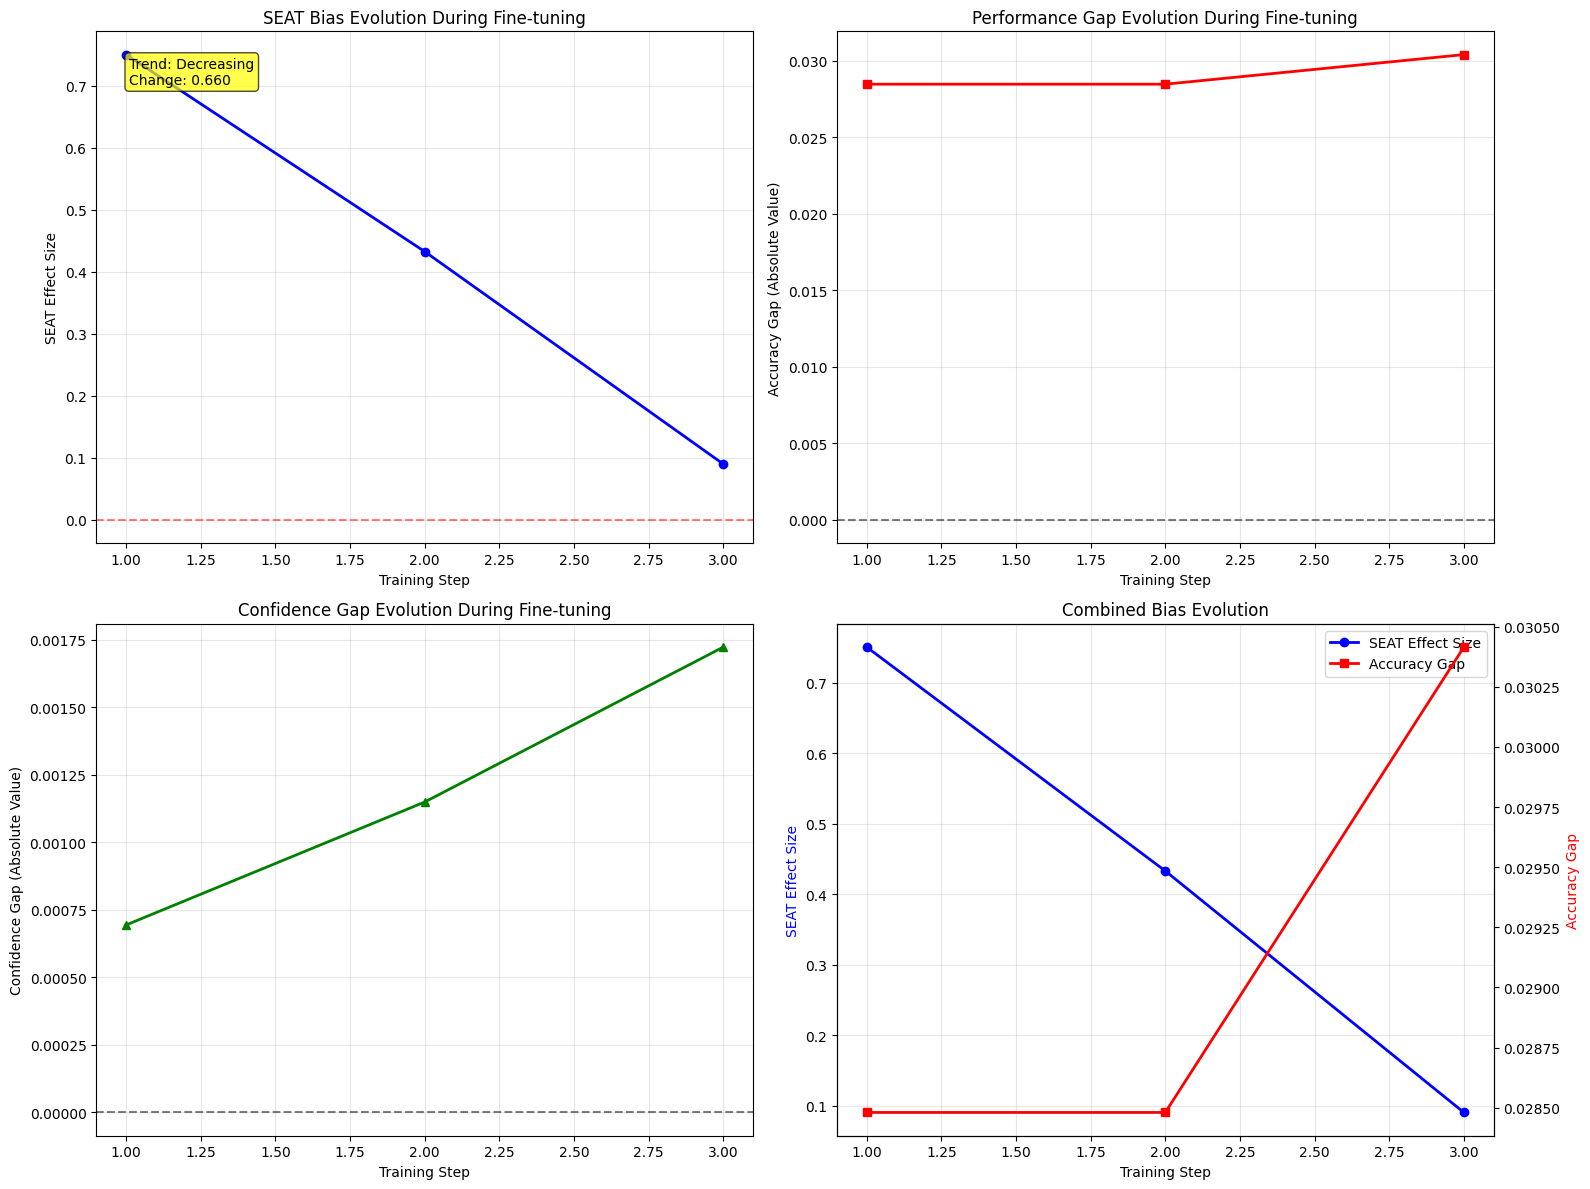

🔍 Analyzing bias propagation patterns...

📈 BIAS PROPAGATION ANALYSIS

🎯 OVERALL BIAS CHANGE:
   Initial SEAT Score: 2.9303
   Final SEAT Score:   2.2262
   Total Change:       -0.7040
   Percent Change:     -24.0%

📊 BIAS TRAJECTORY ANALYSIS:
   Slope:              -0.330058
   R-squared:          0.9995
   P-value:            0.013909
   Trend Direction:    Bias Reduction
   Trend Strength:     Strong

⚡ CRITICAL TRAINING PHASE:
   Largest Change:     -0.3426
   Occurred at Step:   2
   Phase Description:  Bias Drop

🎭 PERFORMANCE DISPARITY ANALYSIS:
   Initial Accuracy Gap: 0.0285
   Final Accuracy Gap:   0.0304
   Gap Change:           0.0019
   SEAT-Performance Correlation: -0.8767 (p=0.3194)

💡 KEY INSIGHTS:
   • SIGNIFICANT bias change detected during fine-tuning
   • Fine-tuning REDUCED pre-existing bias
   • SYSTEMATIC bias evolution pattern detected

✅ Complete bias propagation report saved to ./bias_tracking_results/


In [67]:
report = generate_bias_propagation_report(complete_results, output_dir)

In [68]:
print("Bias trajectory keys:", list(trainer.bias_trajectory.keys()))
print("Bias trajectory content:", trainer.bias_trajectory)

Bias trajectory keys: [1, 2, 3]
Bias trajectory content: {1: {'step': 1, 'epoch': 0.0005589714924538849, 'bias_state': {'seat_effect_size': np.float32(0.7503172), 'seat_male_scores': [np.float32(-0.06084311), np.float32(-0.04537636), np.float32(-0.04352963), np.float32(-0.049996614)], 'seat_female_scores': [np.float32(-0.06570655), np.float32(-0.046094), np.float32(-0.055326283), np.float32(-0.05324632)], 'demographic_performance': {'male': {'accuracy': 0.38104448742746616, 'avg_confidence': np.float64(0.6402785680049623), 'n_examples': 517, 'predictions': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [69]:
def load_bias_tracking_results(results_dir="./bias_tracking_results"):
    """Load saved bias tracking results for further analysis"""
    
    trajectory_file = f"{results_dir}/bias_trajectory.json"
    report_file = f"{results_dir}/bias_propagation_report.json"
    
    results = {}
    
    if os.path.exists(trajectory_file):
        with open(trajectory_file, 'r') as f:
            results['trajectory'] = json.load(f)
    
    if os.path.exists(report_file):
        with open(report_file, 'r') as f:
            results['report'] = json.load(f)
    
    return results

def compare_bias_trajectories(results_list, labels, output_dir="./bias_comparison"):
    """Compare bias trajectories from multiple experiments"""
    
    plt.figure(figsize=(12, 8))
    
    for i, (results, label) in enumerate(zip(results_list, labels)):
        if 'trajectory' in results and 'bias_trajectory' in results['trajectory']:
            trajectory = results['trajectory']['bias_trajectory']
            steps = [int(step) for step in trajectory.keys()]
            seat_scores = [trajectory[str(step)]['seat_effect_size'] for step in steps]
            
            plt.plot(steps, seat_scores, 'o-', linewidth=2, label=label, alpha=0.8)
    
    plt.xlabel('Training Step')
    plt.ylabel('SEAT Effect Size')
    plt.title('Bias Propagation Comparison Across Experiments')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f"{output_dir}/bias_trajectory_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

def print_quick_summary(results_dir="./bias_tracking_results"):
    """Print a quick summary of bias tracking results"""
    
    try:
        results = load_bias_tracking_results(results_dir)
        
        if 'report' in results:
            report = results['report']
            summary = report['experiment_summary']
            analysis = report['propagation_analysis']
            
            print("\n📋 QUICK BIAS PROPAGATION SUMMARY")
            print("-" * 40)
            print(f"Training Steps: {summary['total_training_steps']}")
            print(f"Bias Measurements: {summary['bias_measurements_taken']}")
            print(f"Initial SEAT Score: {summary['initial_seat_score']:.4f}")
            print(f"Final SEAT Score: {summary['final_seat_score']:.4f}")
            print(f"Bias Change: {analysis['bias_change']:.4f}")
            print(f"Percent Change: {analysis['percent_change']:.1f}%")
            
            print(f"\n💡 Recommendations:")
            for rec in report['recommendations']:
                print(f"   • {rec}")
        else:
            print("❌ No bias tracking report found!")
            
    except Exception as e:
        print(f"❌ Error loading results: {str(e)}")

# =============================================================================
# EXAMPLE USAGE
# =============================================================================

if __name__ == "__main__":
    # Run complete analysis
    print("Starting bias propagation tracking analysis...")
    
    # Option 1: Run full analysis
    results, report = run_complete_bias_propagation_analysis(
        model_name='bert-base-uncased',
        output_dir="./bias_tracking_results"
    )
    
    # Option 2: Quick summary of existing results
    # print_quick_summary("./bias_tracking_results")
    
    # Option 3: Load and analyze saved results
    # saved_results = load_bias_tracking_results("./bias_tracking_results")
    
    print("\n✅ Analysis complete! Check the output directory for detailed results.")

Starting bias propagation tracking analysis...


NameError: name 'run_complete_bias_propagation_analysis' is not defined